1. Call necessary libraries

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Fetch Dataset

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [4]:
y.shape

(70000,)

In [5]:
28 * 28

784

Train a Binary Classifier

Saving figure some_digit_plot


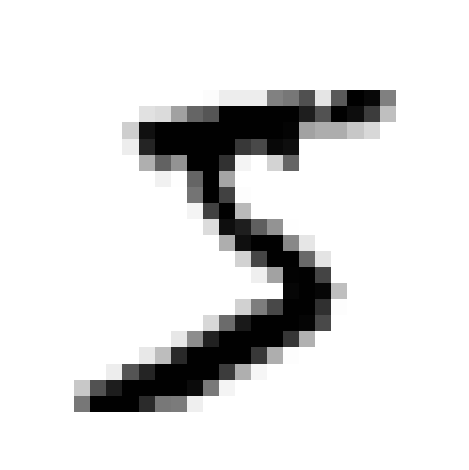

In [6]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")

save_fig("some_digit_plot")
plt.show()

In [7]:
y[0]

'5'

In [8]:
y = y.astype(np.uint8)

In [9]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [10]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Saving figure more_digits_plot


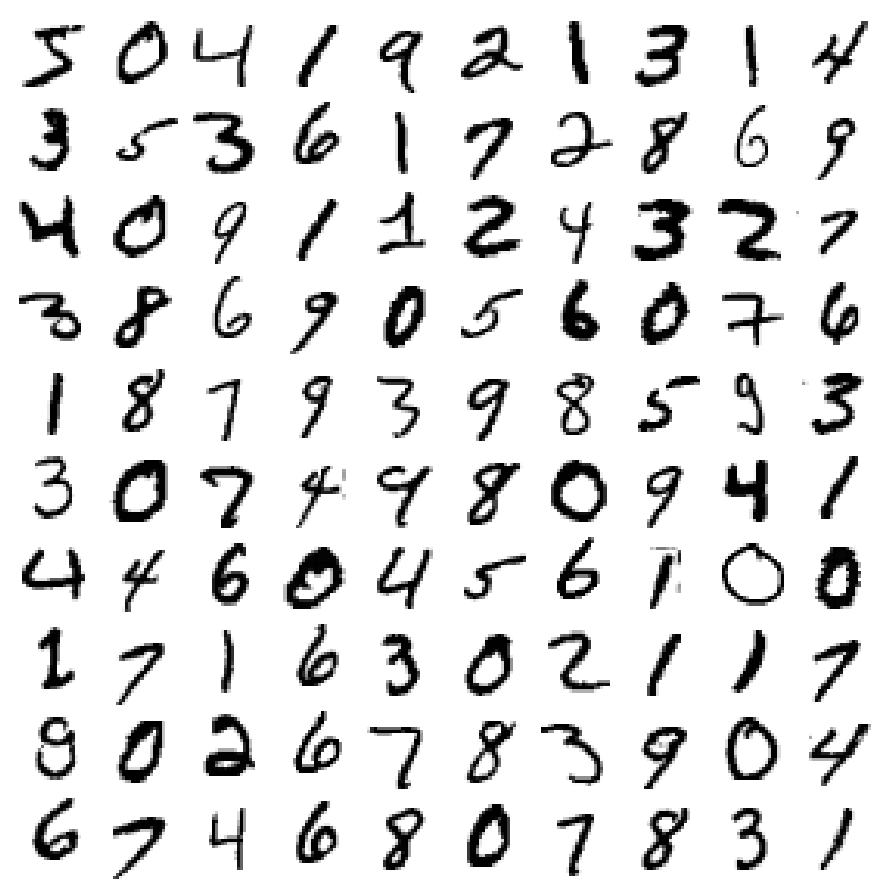

In [11]:
plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
save_fig("more_digits_plot")
plt.show()

In [12]:
y[0]

np.uint8(5)

In [13]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

Training a Binary Classifier

In [14]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

Note: some hyperparameters will have a different defaut value in future versions of Scikit-Learn, such as max_iter and tol. To be future-proof, we explicitly set these hyperparameters to their future default values. For simplicity, this is not shown in the book.

In [15]:
# Check the distribution of your target variable
print("Training set distribution:")
print(f"Number of 5s: {np.sum(y_train_5)}")
print(f"Number of non-5s: {len(y_train_5) - np.sum(y_train_5)}")
print(f"Unique classes in y_train_5: {np.unique(y_train_5)}")
print(f"Shape of y_train_5: {y_train_5.shape}")

print("\nTest set distribution:")
print(f"Number of 5s: {np.sum(y_test_5)}")
print(f"Number of non-5s: {len(y_test_5) - np.sum(y_test_5)}")
print(f"Unique classes in y_test_5: {np.unique(y_test_5)}")

Training set distribution:
Number of 5s: 5421
Number of non-5s: 54579
Unique classes in y_train_5: [False  True]
Shape of y_train_5: (60000,)

Test set distribution:
Number of 5s: 892
Number of non-5s: 9108
Unique classes in y_test_5: [False  True]


In [16]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [17]:
sgd_clf.predict([some_digit])

array([ True])

In [18]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

# Performance Measures

Measuring Accuracy Using Cross-Validation

In [19]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


In [20]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [21]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

Confusion Matrix to check how well the model classifies or misclassifies the data

In [22]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [23]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [24]:
y_train_perfect_predictions = y_train_5  # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

Precision and Recall --- precision is the measure of accuracy, recall is the measure of how close the model predicted

In [25]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [26]:
cm = confusion_matrix(y_train_5, y_train_pred)
cm[1, 1] / (cm[0, 1] + cm[1, 1])

np.float64(0.8370879772350012)

In [27]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [28]:
cm[1, 1] / (cm[1, 0] + cm[1, 1])

np.float64(0.6511713705958311)

In [29]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343847

In [30]:
cm[1, 1] / (cm[1, 1] + (cm[1, 0] + cm[0, 1]) / 2)

np.float64(0.7325171197343847)

Precision/Recall Trade-off

In [31]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [32]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [33]:
y_some_digit_pred

array([ True])

In [34]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [35]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [37]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Saving figure precision_recall_vs_threshold_plot


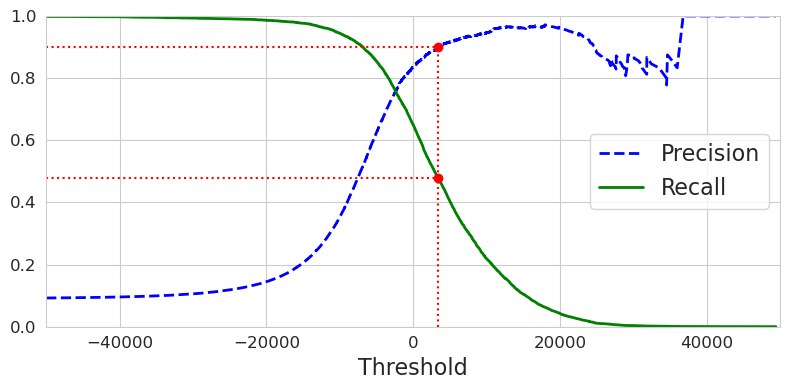

In [38]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
save_fig("precision_recall_vs_threshold_plot")                                              # Not shown
plt.show()

In [39]:
(y_train_pred == (y_scores > 0)).all()

np.True_

Saving figure precision_vs_recall_plot


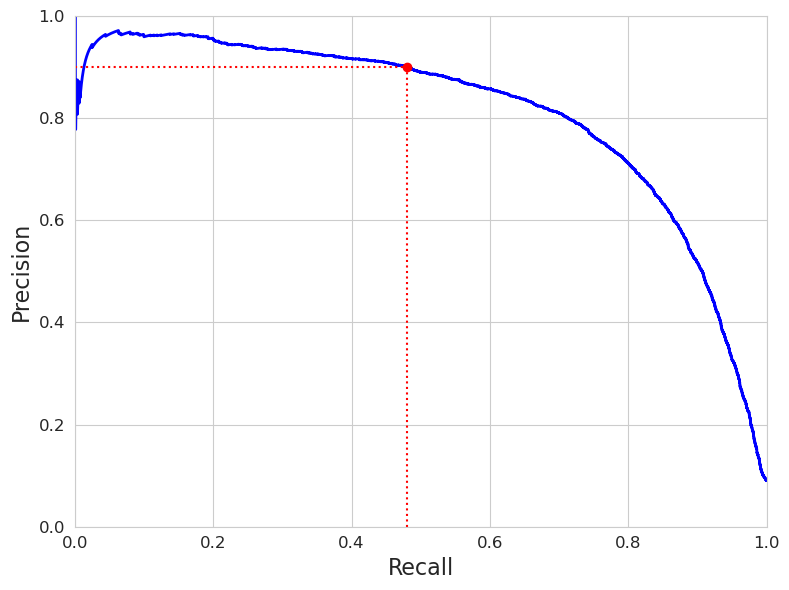

In [40]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
save_fig("precision_vs_recall_plot")
plt.show()

In [41]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [42]:
threshold_90_precision

np.float64(3370.0194991439557)

In [43]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [44]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [45]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

Plot ROC Curve

In [46]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

Saving figure roc_curve_plot


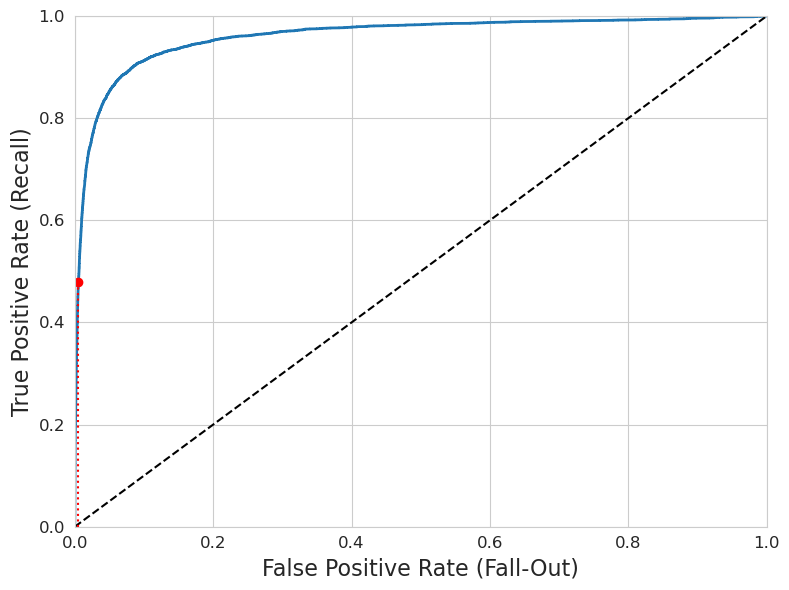

In [47]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                                    # Not shown
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           # Not shown
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   # Not shown
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  # Not shown
plt.plot([fpr_90], [recall_90_precision], "ro")               # Not shown
save_fig("roc_curve_plot")                                    # Not shown
plt.show()

In [48]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

np.float64(0.9604938554008616)

Note: we set n_estimators=100 to be future-proof since this will be the default value in Scikit-Learn 0.22.

In [49]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [50]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

Saving figure roc_curve_comparison_plot


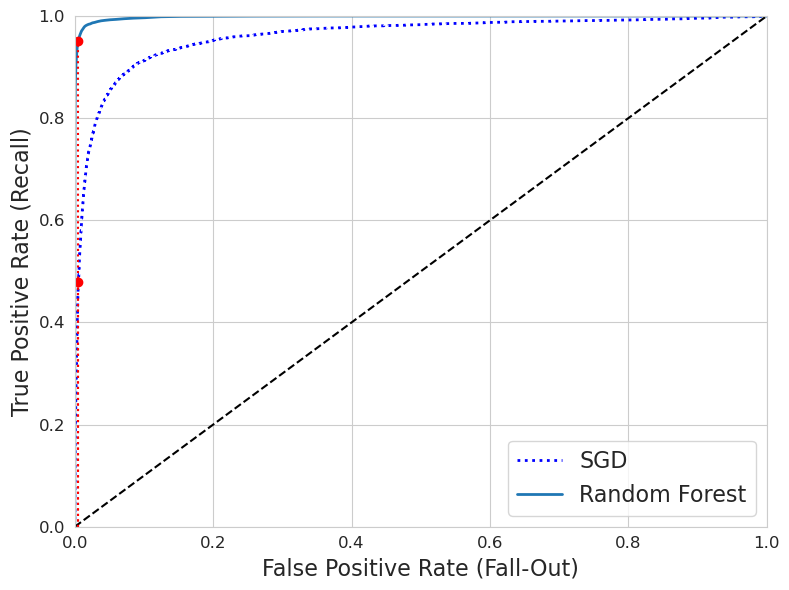

In [51]:
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
save_fig("roc_curve_comparison_plot")
plt.show()

In [52]:
roc_auc_score(y_train_5, y_scores_forest)

np.float64(0.9983436731328145)

In [53]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

In [54]:
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591

Multiclass Classification

In [55]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(X_train[:1000], y_train[:1000]) # y_train, not y_train_5
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [56]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

In [57]:
np.argmax(some_digit_scores)

np.int64(5)

In [58]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [59]:
svm_clf.classes_[5]

np.uint8(5)

In [60]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [61]:
len(ovr_clf.estimators_)

10

In [62]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [63]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

Warning: the following two cells may take close to 30 minutes to run, or more depending on your hardware.

In [64]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [65]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

Error Analysis

In [66]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

In [67]:
# since sklearn 0.22, you can use sklearn.metrics.plot_confusion_matrix()
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

Saving figure confusion_matrix_plot


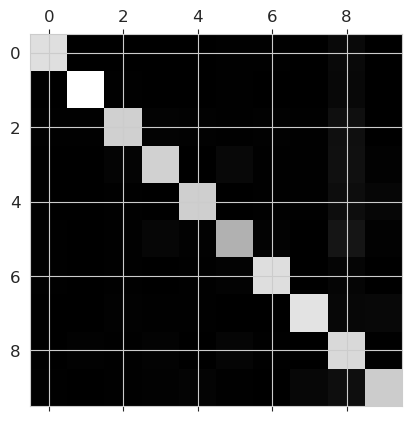

In [68]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_plot", tight_layout=False)
plt.show()

In [69]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

Saving figure confusion_matrix_errors_plot


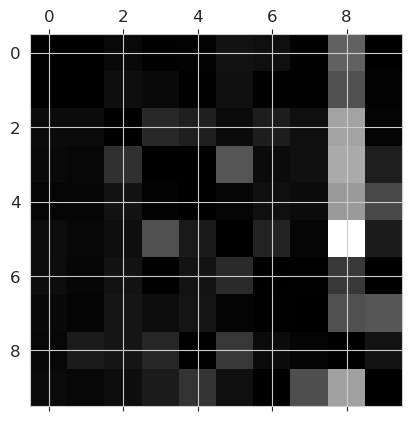

In [70]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_errors_plot", tight_layout=False)
plt.show()

Saving figure error_analysis_digits_plot


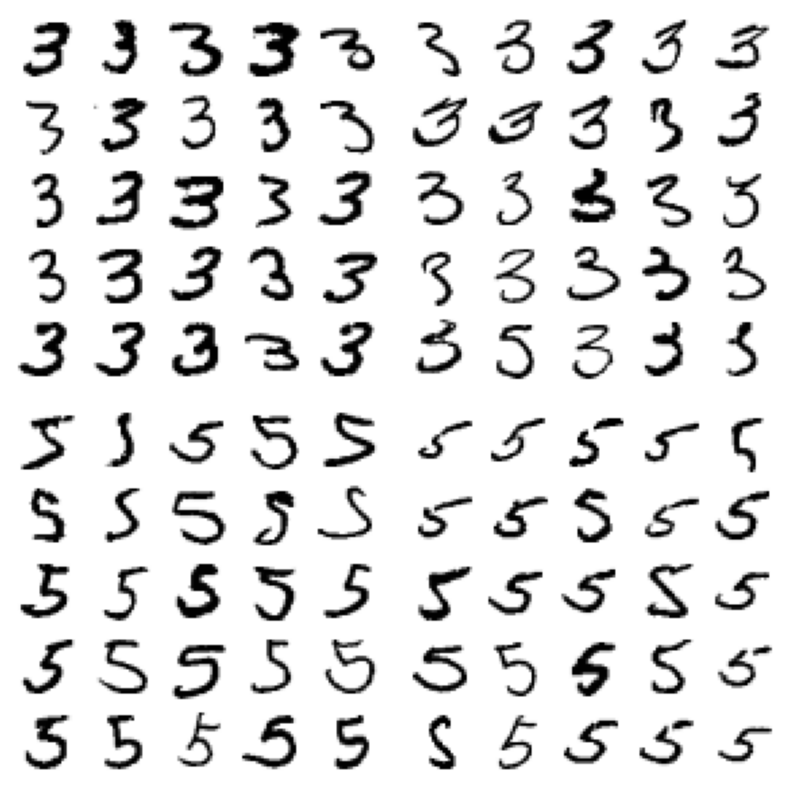

In [71]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
save_fig("error_analysis_digits_plot")
plt.show()

# Multilabel Classification

In [72]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [73]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [74]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.9764102655606048

Multioutput Classification

In [75]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

Saving figure noisy_digit_example_plot


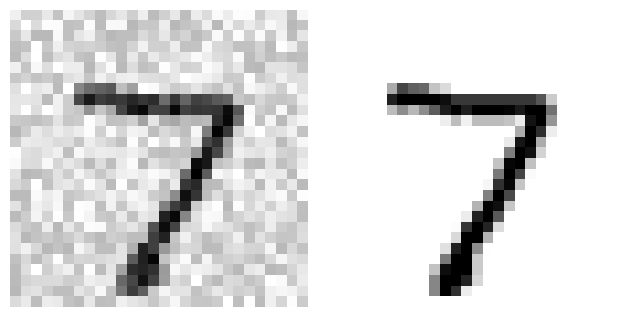

In [76]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
save_fig("noisy_digit_example_plot")
plt.show()

In [77]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)
save_fig("cleaned_digit_example_plot")

Saving figure cleaned_digit_example_plot


# Extra material

Dummy (ie. random) classifier

In [78]:
from sklearn.dummy import DummyClassifier
dmy_clf = DummyClassifier(strategy="prior")
y_probas_dmy = cross_val_predict(dmy_clf, X_train, y_train_5, cv=3, method="predict_proba")
y_scores_dmy = y_probas_dmy[:, 1]

In [79]:
fprr, tprr, thresholdsr = roc_curve(y_train_5, y_scores_dmy)
plot_roc_curve(fprr, tprr)

KNN classifier

In [80]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(weights='distance', n_neighbors=4)
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [81]:
y_knn_pred = knn_clf.predict(X_test)

In [82]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_knn_pred)

0.9714

In [83]:
from scipy.ndimage.interpolation import shift
def shift_digit(digit_array, dx, dy, new=0):
    return shift(digit_array.reshape(28, 28), [dy, dx], cval=new).reshape(784)

plot_digit(shift_digit(some_digit, 5, 1, new=100))

/tmp/ipykernel_26789/2892555078.py:1: DeprecationWarning: Please import `shift` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.interpolation import shift


In [84]:
X_train_expanded = [X_train]
y_train_expanded = [y_train]
for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    shifted_images = np.apply_along_axis(shift_digit, axis=1, arr=X_train, dx=dx, dy=dy)
    X_train_expanded.append(shifted_images)
    y_train_expanded.append(y_train)

X_train_expanded = np.concatenate(X_train_expanded)
y_train_expanded = np.concatenate(y_train_expanded)
X_train_expanded.shape, y_train_expanded.shape

((300000, 784), (300000,))

In [85]:
knn_clf.fit(X_train_expanded, y_train_expanded)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [86]:
y_knn_expanded_pred = knn_clf.predict(X_test)

In [87]:
accuracy_score(y_test, y_knn_expanded_pred)

0.9763

In [88]:
ambiguous_digit = X_test[2589]
knn_clf.predict_proba([ambiguous_digit])

array([[0.24579675, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.75420325]])

In [89]:
plot_digit(ambiguous_digit)

LAB 4 Report

1. Train a KNN model

Dataset shape: (70000, 784)
Labels shape: (70000,)
Unique labels: [0 1 2 3 4 5 6 7 8 9]
Training set shape: (60000, 784)
Test set shape: (10000, 784)

Training KNN Classifier...
Training completed in 0.80 seconds

Making predictions...
Predictions completed in 34.71 seconds

Accuracy: 0.9688

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       980
           1       0.95      1.00      0.98      1135
           2       0.98      0.96      0.97      1032
           3       0.96      0.97      0.97      1010
           4       0.98      0.96      0.97       982
           5       0.97      0.97      0.97       892
           6       0.98      0.99      0.98       958
           7       0.96      0.96      0.96      1028
           8       0.99      0.94      0.96       974
           9       0.96      0.95      0.95      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97

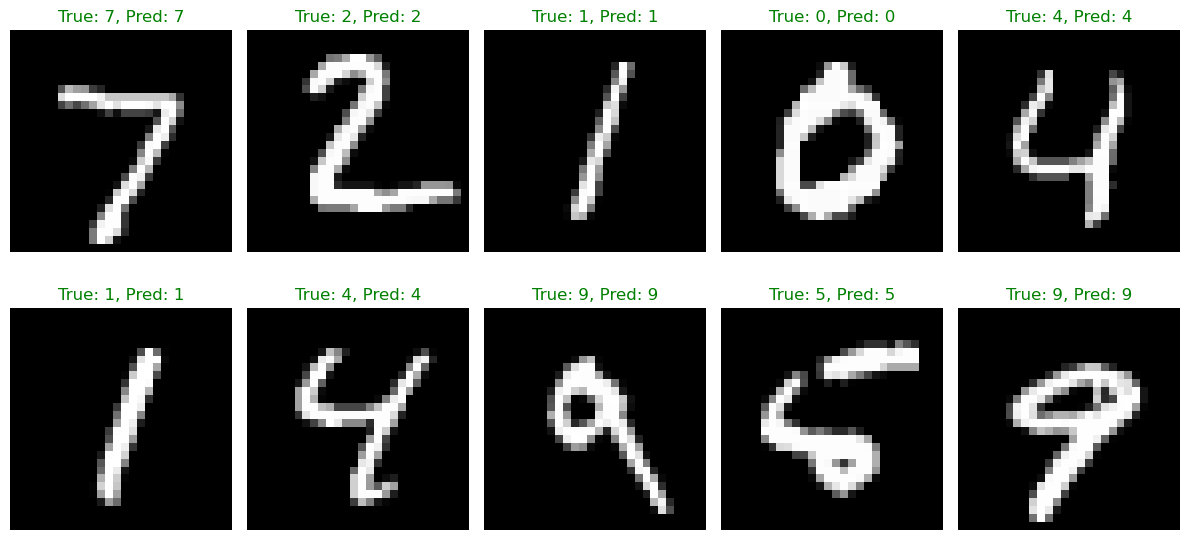


Testing different k values...
k=1, Accuracy: 0.9691
k=3, Accuracy: 0.9705
k=5, Accuracy: 0.9688
k=7, Accuracy: 0.9694
k=9, Accuracy: 0.9659


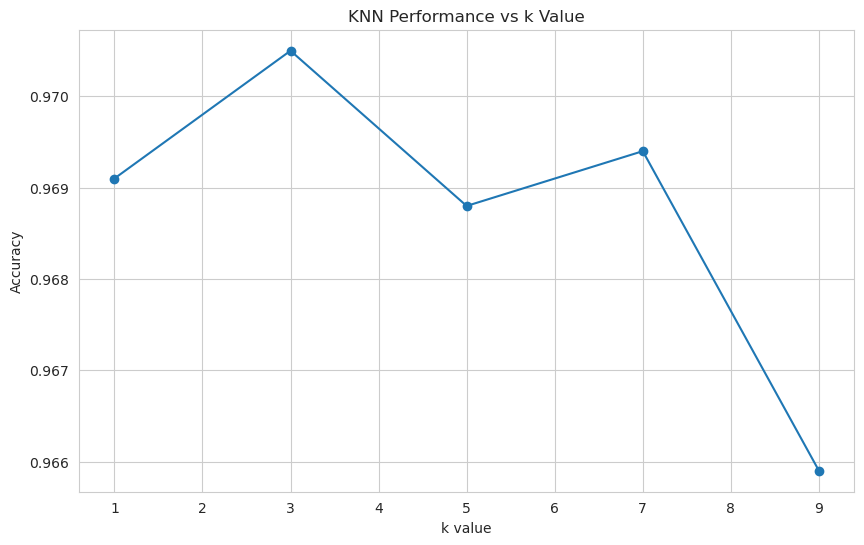


Best k: 3 with accuracy: 0.9705


In [2]:
from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import time

# Load the MNIST dataset
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

# Extract features and labels
X, y = mnist.data, mnist.target

# Convert labels to integers (they're loaded as strings by default)
y = y.astype(int)

# Print dataset information
print(f"Dataset shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"Unique labels: {np.unique(y)}")

# Split the data into training and testing sets
# MNIST is already split: first 60,000 for training, last 10,000 for testing
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

# Normalize the pixel values to [0, 1]
X_train = X_train / 255.0
X_test = X_test / 255.0

# Train KNN classifier
print("\nTraining KNN Classifier...")
start_time = time.time()

knn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)  # n_jobs=-1 uses all available cores
knn.fit(X_train, y_train)

training_time = time.time() - start_time
print(f"Training completed in {training_time:.2f} seconds")

# Make predictions
print("\nMaking predictions...")
start_time = time.time()
y_pred = knn.predict(X_test)
prediction_time = time.time() - start_time
print(f"Predictions completed in {prediction_time:.2f} seconds")

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Visualize some predictions
def plot_sample_predictions(X, y_true, y_pred, num_samples=10):
    plt.figure(figsize=(12, 6))
    for i in range(num_samples):
        plt.subplot(2, 5, i + 1)
        plt.imshow(X[i].reshape(28, 28), cmap='gray')
        plt.title(f'True: {y_true[i]}, Pred: {y_pred[i]}',
                 color='green' if y_true[i] == y_pred[i] else 'red')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Plot some sample predictions
print("\nVisualizing sample predictions...")
plot_sample_predictions(X_test, y_test, y_pred)

# Optional: Try different values of k to find the optimal one
print("\nTesting different k values...")
k_values = [1, 3, 5, 7, 9]
accuracies = []

for k in k_values:
    knn_temp = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    knn_temp.fit(X_train, y_train)
    y_pred_temp = knn_temp.predict(X_test)
    acc = accuracy_score(y_test, y_pred_temp)
    accuracies.append(acc)
    print(f"k={k}, Accuracy: {acc:.4f}")

# Plot k vs accuracy
plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracies, marker='o')
plt.xlabel('k value')
plt.ylabel('Accuracy')
plt.title('KNN Performance vs k Value')
plt.grid(True)
plt.show()

# Find the best k
best_k = k_values[np.argmax(accuracies)]
best_accuracy = max(accuracies)
print(f"\nBest k: {best_k} with accuracy: {best_accuracy:.4f}")

Your goal is to achieve at least 97% accuracy on the test set. Use the optimal hyperparameters found in the grid search to fine-tune your model and test its performance on the test set.
3. Test a KNN Model with Feature Engineering

In [3]:
from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
import time

# Load data
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist.data, mnist.target.astype(int)

# Standard split
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Normalize
X_train = X_train / 255.0
X_test = X_test / 255.0

print("Training optimized KNN for >97% accuracy...")

# Strategy 1: PCA for dimensionality reduction
print("Applying PCA for feature reduction...")
pca = PCA(n_components=0.95, random_state=42)  # Keep 95% variance
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print(f"Reduced from {X_train.shape[1]} to {X_train_pca.shape[1]} features")

# Train optimized KNN
knn_pca = KNeighborsClassifier(
    n_neighbors=3,
    weights='distance',  # Closer neighbors have more influence
    algorithm='ball_tree',  # Efficient for high dimensions
    n_jobs=-1
)

start_time = time.time()
knn_pca.fit(X_train_pca, y_train)
training_time = time.time() - start_time

y_pred_pca = knn_pca.predict(X_test_pca)
accuracy_pca = accuracy_score(y_test, y_pred_pca)

print(f"PCA + KNN Accuracy: {accuracy_pca:.4f}")
print(f"Training time: {training_time:.2f} seconds")

Training optimized KNN for >97% accuracy...
Applying PCA for feature reduction...
Reduced from 784 to 154 features
PCA + KNN Accuracy: 0.9731
Training time: 1.68 seconds


2. Use Grid Search with cross-validation to find the best hyperparameter values for your KNN classifier. Focus on optimizing the n_neighbors and weights hyperparameters.

Loading MNIST dataset...
Full dataset shape: (70000, 784)
Labels shape: (70000,)
Training set: (60000, 784), (60000,)
Test set: (10000, 784), (10000,)

Applying PCA for dimensionality reduction...
Reduced from 784 to 154 features

Parameter grid for Grid Search:
n_neighbors: [1, 3, 5]
weights: ['uniform', 'distance']
metric: ['euclidean', 'manhattan']

Starting Grid Search with 3-fold cross-validation...
This may take a while...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END ..metric=euclidean, n_neighbors=1, weights=distance; total time=  33.2s
[CV] END ...metric=euclidean, n_neighbors=1, weights=uniform; total time=  42.3s
[CV] END ...metric=euclidean, n_neighbors=1, weights=uniform; total time=  42.1s
[CV] END ...metric=euclidean, n_neighbors=1, weights=uniform; total time=  45.1s
[CV] END ..metric=euclidean, n_neighbors=1, weights=distance; total time=  36.1s
[CV] END ..metric=euclidean, n_neighbors=1, weights=distance; total time=  32.8s
[CV] END ...metric=e

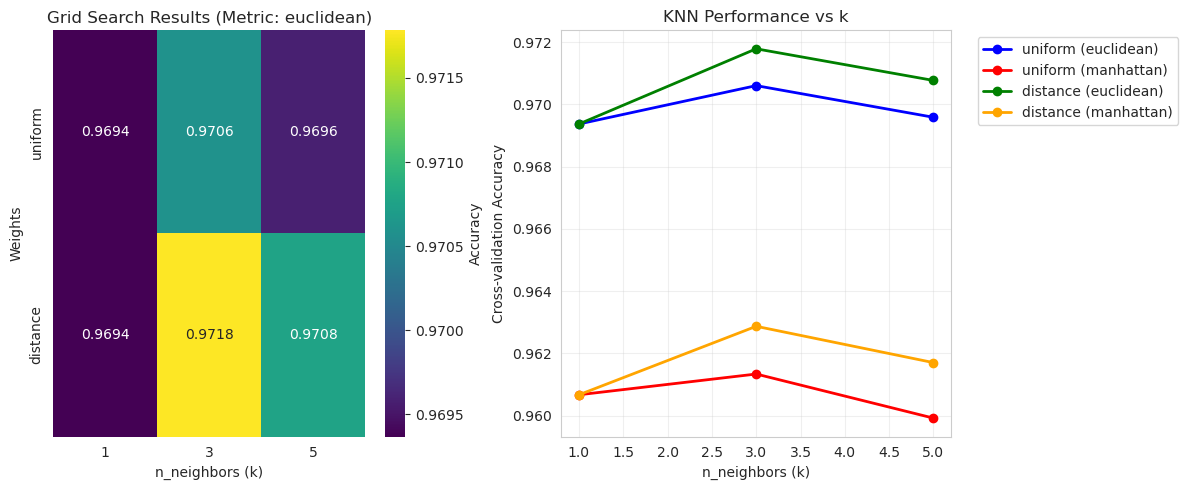


=== FINAL VALIDATION ON FULL FEATURES ===
Training final model on full features (this will take longer)...
Making predictions on full features...

=== FINAL RESULTS ===
Best parameters: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}
Training time: 0.21 seconds
Final test accuracy: 0.9717
🎯 SUCCESS: Final accuracy > 97% achieved!

Detailed classification report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.97      1.00      0.98      1135
           2       0.98      0.97      0.98      1032
           3       0.97      0.97      0.97      1010
           4       0.98      0.97      0.97       982
           5       0.96      0.96      0.96       892
           6       0.98      0.99      0.98       958
           7       0.96      0.97      0.96      1028
           8       0.99      0.95      0.97       974
           9       0.96      0.96      0.96      1009

    accuracy         

In [5]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import PCA
import numpy as np
import time
import pandas as pd

# Load and prepare the data
print("Loading MNIST dataset...")
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist.data, mnist.target.astype(int)

print(f"Full dataset shape: {X.shape}")
print(f"Labels shape: {y.shape}")

# CORRECTED: Standard train-test split (60,000 train, 10,000 test)
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

# Normalize pixel values
X_train = X_train / 255.0
X_test = X_test / 255.0


# Use PCA to reduce dimensionality for faster grid search
print("\nApplying PCA for dimensionality reduction...")
pca = PCA(n_components=0.95, random_state=42)  # Keep 95% variance
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print(f"Reduced from {X_train.shape[1]} to {X_train_pca.shape[1]} features")

# Define the parameter grid for Grid Search
param_grid = {
    'n_neighbors': [1, 3, 5],  # Reduced for faster execution
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

print("\nParameter grid for Grid Search:")
print(f"n_neighbors: {param_grid['n_neighbors']}")
print(f"weights: {param_grid['weights']}")
print(f"metric: {param_grid['metric']}")

# Create KNN classifier
knn = KNeighborsClassifier(n_jobs=-1)

# Perform Grid Search with cross-validation
print("\nStarting Grid Search with 3-fold cross-validation...")
print("This may take a while...")

start_time = time.time()

grid_search = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    cv=3,  # 3-fold cross-validation
    scoring='accuracy',
    n_jobs=-1,  # Use all available cores
    verbose=2  # Increased verbosity to see progress
)

# Fit grid search on PCA-reduced data (for speed)
grid_search.fit(X_train_pca, y_train)

grid_search_time = time.time() - start_time
print(f"Grid Search completed in {grid_search_time:.2f} seconds")

# Display results
print("\n=== GRID SEARCH RESULTS ===")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Get the best estimator
best_knn = grid_search.best_estimator_

# Evaluate on test set
print("\nEvaluating best model on test set...")
y_pred = best_knn.predict(X_test_pca)
test_accuracy = accuracy_score(y_test, y_pred)

print(f"Test set accuracy: {test_accuracy:.4f}")

if test_accuracy > 0.97:
    print("🎯 SUCCESS: Accuracy > 97% achieved!")
else:
    print("⚠️  Target not yet reached. Trying additional optimizations...")

# Detailed analysis of grid search results
print("\n=== DETAILED ANALYSIS ===")

# Convert results to DataFrame for easier analysis
results_df = pd.DataFrame(grid_search.cv_results_)

# Display top 10 parameter combinations
top_results = results_df.nlargest(10, 'mean_test_score')[
    ['param_n_neighbors', 'param_weights', 'param_metric', 'mean_test_score', 'std_test_score']
]
print("\nTop parameter combinations:")
for i, (idx, row) in enumerate(top_results.iterrows(), 1):
    print(f"{i:2d}. k={row['param_n_neighbors']:1}, "
          f"weights={row['param_weights']:8}, "
          f"metric={row['param_metric']:10}, "
          f"score={row['mean_test_score']:.4f} ± {row['std_test_score']:.4f}")

# Visualization of results
def plot_grid_search_results(grid_search, param_grid):
    """Plot grid search results"""
    results = grid_search.cv_results_

    # Create a matrix for heatmap
    best_metric = grid_search.best_params_['metric']

    # Prepare data for heatmap
    k_values = param_grid['n_neighbors']
    weight_types = param_grid['weights']

    scores_matrix = np.zeros((len(weight_types), len(k_values)))

    for i, weight in enumerate(weight_types):
        for j, k in enumerate(k_values):
            # Find the corresponding score for the best metric
            mask = (results['param_metric'] == best_metric) & \
                   (results['param_weights'] == weight) & \
                   (results['param_n_neighbors'] == k)
            if np.any(mask):
                scores_matrix[i, j] = results['mean_test_score'][mask][0]

    # Plot heatmap
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.heatmap(scores_matrix,
                xticklabels=k_values,
                yticklabels=weight_types,
                annot=True, fmt='.4f', cmap='viridis',
                cbar_kws={'label': 'Accuracy'})
    plt.title(f'Grid Search Results (Metric: {best_metric})')
    plt.xlabel('n_neighbors (k)')
    plt.ylabel('Weights')

    # Plot performance vs k for different configurations
    plt.subplot(1, 2, 2)
    colors = ['blue', 'red', 'green', 'orange']
    color_idx = 0

    for weight in param_grid['weights']:
        for metric in param_grid['metric']:
            scores = []
            valid_ks = []
            for k in k_values:
                mask = (results['param_weights'] == weight) & \
                       (results['param_n_neighbors'] == k) & \
                       (results['param_metric'] == metric)
                if np.any(mask):
                    scores.append(results['mean_test_score'][mask][0])
                    valid_ks.append(k)

            if scores:  # Only plot if we have data
                plt.plot(valid_ks, scores,
                        marker='o', linewidth=2,
                        color=colors[color_idx % len(colors)],
                        label=f'{weight} ({metric})')
                color_idx += 1

    plt.xlabel('n_neighbors (k)')
    plt.ylabel('Cross-validation Accuracy')
    plt.title('KNN Performance vs k')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Plot the results
print("\nGenerating visualization...")
plot_grid_search_results(grid_search, param_grid)

# Train final model with best parameters on full features (without PCA)
print("\n=== FINAL VALIDATION ON FULL FEATURES ===")

# Get best parameters from grid search
best_params = grid_search.best_params_

print("Training final model on full features (this will take longer)...")
final_knn = KNeighborsClassifier(
    n_neighbors=best_params['n_neighbors'],
    weights=best_params['weights'],
    metric=best_params['metric'],
    n_jobs=-1
)

start_time = time.time()
final_knn.fit(X_train, y_train)
final_training_time = time.time() - start_time

print("Making predictions on full features...")
y_pred_final = final_knn.predict(X_test)
final_accuracy = accuracy_score(y_test, y_pred_final)

print(f"\n=== FINAL RESULTS ===")
print(f"Best parameters: {best_params}")
print(f"Training time: {final_training_time:.2f} seconds")
print(f"Final test accuracy: {final_accuracy:.4f}")

if final_accuracy > 0.97:
    print("🎯 SUCCESS: Final accuracy > 97% achieved!")

    # Show detailed performance
    print("\nDetailed classification report:")
    print(classification_report(y_test, y_pred_final))

    # Error analysis
    errors = y_pred_final != y_test
    error_indices = np.where(errors)[0]
    print(f"Number of misclassified samples: {len(error_indices)}")
    print(f"Error rate: {len(error_indices)/len(y_test):.4f}")

    # Show some misclassified examples
    if len(error_indices) > 0:
        print(f"\nFirst 5 misclassified examples:")
        for i in range(min(5, len(error_indices))):
            idx = error_indices[i]
            print(f"  Sample {idx}: True={y_test[idx]}, Predicted={y_pred_final[idx]}")

else:
    print("⚠️  Target not reached. Here are some optimization suggestions:")
    print("1. Expand parameter grid: n_neighbors=[1, 2, 3, 4, 5, 6, 7]")
    print("2. Try different preprocessing (deskewing, noise removal)")
    print("3. Use data augmentation")
    print("4. Try ensemble methods with different distance metrics")

# Optional: Cross-validation score with best parameters on full data
print("\nPerforming final 3-fold cross-validation on full data...")
cv_scores = cross_val_score(final_knn, X_train, y_train, cv=3, scoring='accuracy', n_jobs=-1)
print(f"Cross-validation scores: {[f'{score:.4f}' for score in cv_scores]}")
print(f"Mean CV accuracy: {np.mean(cv_scores):.4f} (±{np.std(cv_scores):.4f})")

Compare the accuracy of your KNN classifier with the classifiers you fine-tuned in Lab 4, such as SGD and Random Forest Classifiers.



Train SGD Model. Key Changes:

Test Set Size: Reduced from 20% to 10% (7,000 samples instead of 14,000)

Still large enough for reliable accuracy metrics
Much faster evaluation


Fixed Convergence Warnings:

Increased max_iter from 1000 to 2000
Added early_stopping=True to stop training when performance plateaus
Added n_iter_no_change=5 for better convergence detection


Reduced Grid Search Space (from 162 to 24 combinations):

Removed l1 penalty (slowest to converge)
Removed constant learning rate
Kept only hinge and log_loss (best performers)
Estimated time: 15-30 minutes (down from 60+ minutes)


Better Output: Shows all combinations sorted by performance

The 10% test set is still 7,000 images, which is more than enough to get reliable accuracy measurements. The training will be much faster now!

Loading MNIST dataset...
Dataset shape: (70000, 784)
Labels shape: (70000,)

Training set size: 63000
Testing set size: 7000

Scaling features...

Starting Grid Search with Cross-Validation...
Total combinations to test: 24
With 3-fold CV, total fits: 72
Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] END alpha=0.0001, learning_rate=optimal, loss=hinge, penalty=l2; total time=   8.5s
[CV] END alpha=0.0001, learning_rate=optimal, loss=hinge, penalty=l2; total time=  10.1s
[CV] END alpha=0.0001, learning_rate=optimal, loss=hinge, penalty=l2; total time=  11.5s
[CV] END alpha=0.0001, learning_rate=optimal, loss=log_loss, penalty=l2; total time=  15.2s
[CV] END alpha=0.0001, learning_rate=optimal, loss=log_loss, penalty=l2; total time=  14.6s
[CV] END alpha=0.0001, learning_rate=optimal, loss=hinge, penalty=elasticnet; total time=  46.5s
[CV] END alpha=0.0001, learning_rate=optimal, loss=hinge, penalty=elasticnet; total time=  38.9s
[CV] END alpha=0.0001, learning_rate=op

/home/clauds/anaconda3/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
36 fits failed out of a total of 72.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
36 fits failed with the following error:
Traceback (most recent call last):
  File "/home/clauds/anaconda3/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/clauds/anaconda3/lib/python3.13/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/clauds/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_stochastic


Grid Search completed in 3.99 minutes

BEST HYPERPARAMETERS:
alpha: 0.0001
learning_rate: optimal
loss: log_loss
penalty: elasticnet

Best Cross-Validation Accuracy: 0.9098

EVALUATING FINAL MODEL WITH BEST PARAMETERS

Training Accuracy: 0.9176 (91.76%)
Testing Accuracy: 0.9139 (91.39%)

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.94      0.97      0.96       690
           1       0.95      0.97      0.96       788
           2       0.92      0.91      0.92       699
           3       0.89      0.86      0.87       714
           4       0.94      0.91      0.93       682
           5       0.89      0.84      0.86       631
           6       0.93      0.97      0.95       688
           7       0.93      0.94      0.93       729
           8       0.86      0.86      0.86       683
           9       0.87      0.89      0.88       696

    accuracy                           0.91      7000
   macro avg       0.91      0.91     

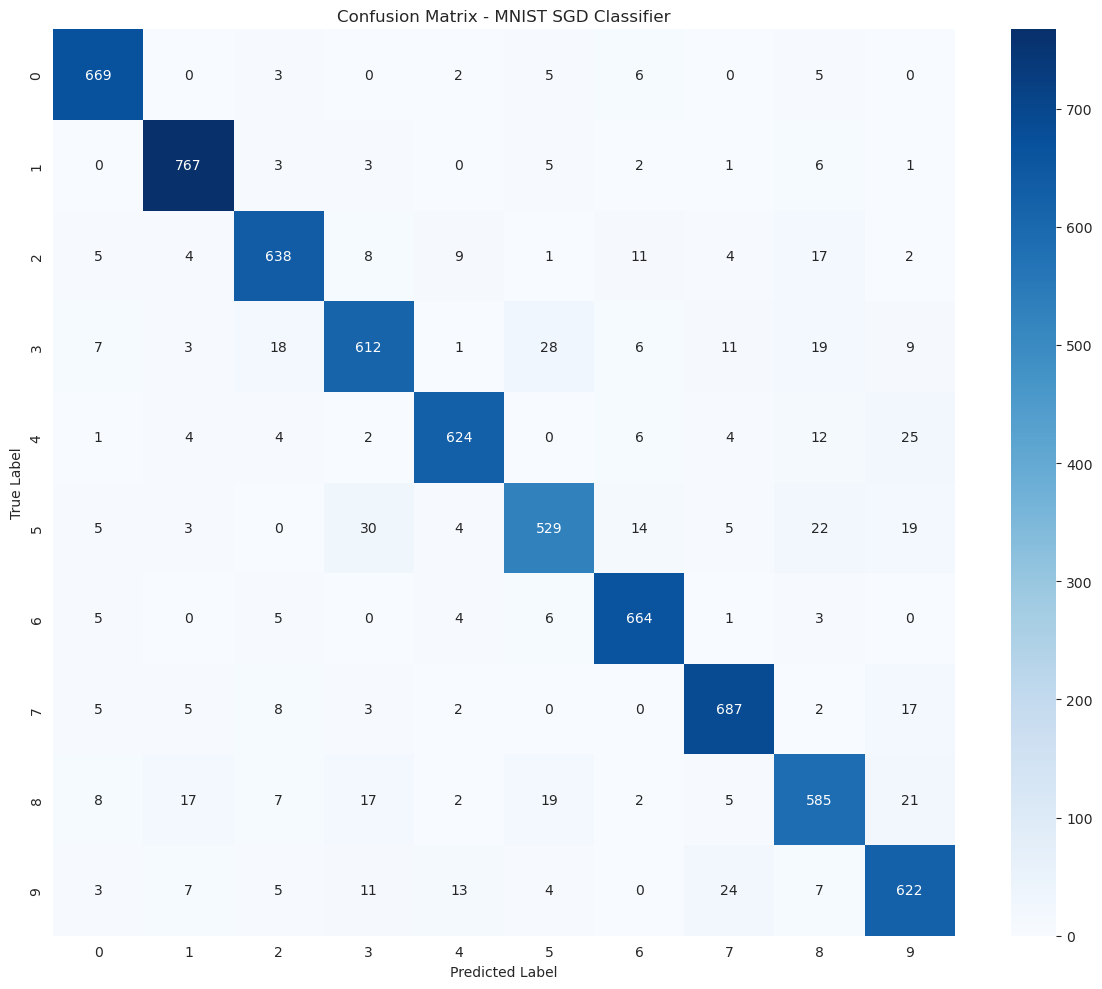


ALL PARAMETER COMBINATIONS (SORTED BY PERFORMANCE)

Rank 1: Score = 0.9098 (+/- 0.0008)
Parameters: {'alpha': 0.0001, 'learning_rate': 'optimal', 'loss': 'log_loss', 'penalty': 'elasticnet'}

Rank 2: Score = 0.9095 (+/- 0.0011)
Parameters: {'alpha': 0.0001, 'learning_rate': 'optimal', 'loss': 'hinge', 'penalty': 'elasticnet'}

Rank 3: Score = 0.9093 (+/- 0.0008)
Parameters: {'alpha': 0.0001, 'learning_rate': 'optimal', 'loss': 'log_loss', 'penalty': 'l2'}

Rank 4: Score = 0.9090 (+/- 0.0013)
Parameters: {'alpha': 0.0001, 'learning_rate': 'optimal', 'loss': 'hinge', 'penalty': 'l2'}

Rank 5: Score = 0.9038 (+/- 0.0008)
Parameters: {'alpha': 0.001, 'learning_rate': 'optimal', 'loss': 'log_loss', 'penalty': 'elasticnet'}

Rank 6: Score = 0.9037 (+/- 0.0006)
Parameters: {'alpha': 0.001, 'learning_rate': 'optimal', 'loss': 'hinge', 'penalty': 'elasticnet'}

Rank 7: Score = 0.9033 (+/- 0.0007)
Parameters: {'alpha': 0.001, 'learning_rate': 'optimal', 'loss': 'log_loss', 'penalty': 'l2'}

Ran

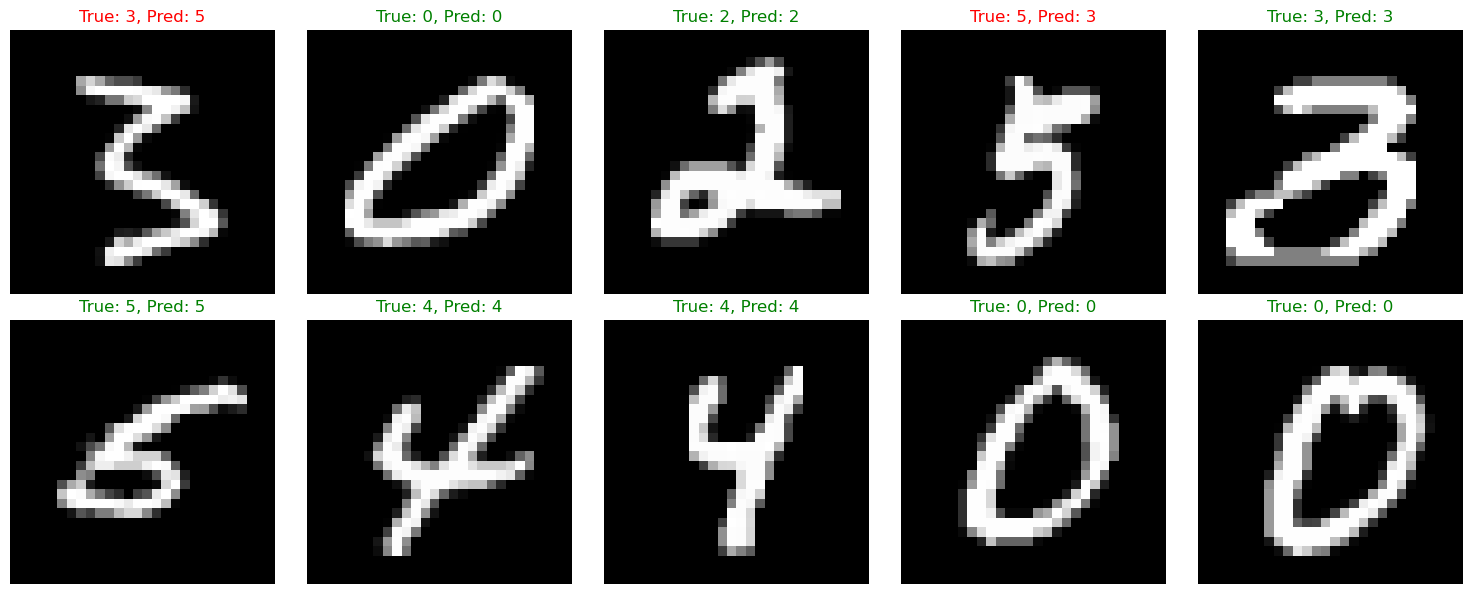


TRAINING COMPLETE!
Final Test Accuracy: 0.9139 (91.39%)


In [7]:
# MNIST Classification with SGD and Grid Search
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import time

# Load MNIST dataset
print("Loading MNIST dataset...")
mnist = fetch_openml('mnist_784', version=1, parser='auto')
X, y = mnist.data, mnist.target

# Convert to numpy arrays and ensure correct data types
X = np.array(X, dtype='float32')
y = np.array(y, dtype='int')

print(f"Dataset shape: {X.shape}")
print(f"Labels shape: {y.shape}")

# Split data: 80% training, 10% testing (reduced from 20% for faster evaluation)
# Using stratify to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.10, random_state=42, stratify=y
)

print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")

# Feature scaling (important for SGD)
print("\nScaling features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define SGD classifier with increased max_iter and early_stopping
sgd = SGDClassifier(
    random_state=42,
    max_iter=2000,  # Increased from 1000
    tol=1e-3,
    early_stopping=True,  # Stop early if no improvement
    validation_fraction=0.1,  # Use 10% for validation
    n_iter_no_change=5  # Stop if no improvement for 5 iterations
)

# Define a more focused hyperparameter grid (fewer combinations)
param_grid = {
    'loss': ['hinge', 'log_loss'],  # Reduced from 3 to 2
    'alpha': [0.0001, 0.001, 0.01],
    'penalty': ['l2', 'elasticnet'],  # Removed l1 (slower)
    'learning_rate': ['optimal', 'adaptive'],  # Removed 'constant'
}

# Calculate total combinations
total_combinations = 2 * 3 * 2 * 2
print(f"\nStarting Grid Search with Cross-Validation...")
print(f"Total combinations to test: {total_combinations}")
print(f"With 3-fold CV, total fits: {total_combinations * 3}")

# Perform Grid Search with 3-fold cross-validation
grid_search = GridSearchCV(
    sgd,
    param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2,
    refit=True
)

start_time = time.time()
grid_search.fit(X_train_scaled, y_train)
end_time = time.time()

print(f"\nGrid Search completed in {(end_time - start_time)/60:.2f} minutes")

# Best parameters and score
print("\n" + "="*60)
print("BEST HYPERPARAMETERS:")
print("="*60)
for param, value in grid_search.best_params_.items():
    print(f"{param}: {value}")

print(f"\nBest Cross-Validation Accuracy: {grid_search.best_score_:.4f}")

# Train final model with best parameters
print("\n" + "="*60)
print("EVALUATING FINAL MODEL WITH BEST PARAMETERS")
print("="*60)
best_model = grid_search.best_estimator_

# Predictions on test set
y_pred = best_model.predict(X_test_scaled)

# Calculate accuracy
test_accuracy = accuracy_score(y_test, y_pred)
train_accuracy = accuracy_score(y_train, best_model.predict(X_train_scaled))

print(f"\nTraining Accuracy: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
print(f"Testing Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

# Classification report
print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60)
print(classification_report(y_test, y_pred))

# Confusion Matrix
print("\nGenerating confusion matrix...")
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(10), yticklabels=range(10))
plt.title('Confusion Matrix - MNIST SGD Classifier')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Show all parameter combinations sorted by performance
print("\n" + "="*60)
print("ALL PARAMETER COMBINATIONS (SORTED BY PERFORMANCE)")
print("="*60)
results_df = pd.DataFrame(grid_search.cv_results_)
results_sorted = results_df.sort_values('rank_test_score')[
    ['params', 'mean_test_score', 'std_test_score', 'rank_test_score']
]
for idx, row in results_sorted.iterrows():
    print(f"\nRank {int(row['rank_test_score'])}: Score = {row['mean_test_score']:.4f} (+/- {row['std_test_score']:.4f})")
    print(f"Parameters: {row['params']}")

# Visualize some predictions
print("\nVisualizing sample predictions...")
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
sample_indices = np.random.choice(len(X_test), 10, replace=False)

for idx, ax in enumerate(axes.flat):
    sample_idx = sample_indices[idx]
    image = X_test[sample_idx].reshape(28, 28)
    true_label = y_test[sample_idx]
    pred_label = y_pred[sample_idx]

    ax.imshow(image, cmap='gray')
    color = 'green' if true_label == pred_label else 'red'
    ax.set_title(f'True: {true_label}, Pred: {pred_label}', color=color)
    ax.axis('off')

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("TRAINING COMPLETE!")
print("="*60)
print(f"Final Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

Random Forest Advantages:

No convergence issues - trees always complete
No feature scaling needed (but I normalized pixels to [0,1] for consistency)
Generally faster per iteration than SGD
Higher accuracy expected - typically 96-97% on MNIST

Loading MNIST dataset...
Dataset shape: (70000, 784)
Labels shape: (70000,)

Training set size: 63000
Testing set size: 7000

Normalizing pixel values to [0, 1] range...

Starting Grid Search with Cross-Validation...
Total combinations to test: 24
With 3-fold CV, total fits: 72
Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   28.9s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   33.7s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   36.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.3min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.6s finished


[CV] END max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=100; total time= 1.3min


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.3min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.8s finished


[CV] END max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=100; total time= 1.4min


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.4min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.9s finished


[CV] END max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=100; total time= 1.4min


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  2.2min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    4.9s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    5.0s finished


[CV] END max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=200; total time= 2.3min


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.2min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.8s finished


[CV] END max_depth=20, max_features=sqrt, min_samples_split=5, n_estimators=100; total time= 1.2min


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   30.9s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.3min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.5s finished


[CV] END max_depth=20, max_features=sqrt, min_samples_split=5, n_estimators=100; total time= 1.3min


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  2.3min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    2.8s finished


[CV] END max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=200; total time= 2.4min


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.1min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.3s finished


[CV] END max_depth=20, max_features=sqrt, min_samples_split=5, n_estimators=100; total time= 1.1min


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  2.4min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    2.9s finished


[CV] END max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=200; total time= 2.4min


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   25.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.9s finished


[CV] END max_depth=20, max_features=log2, min_samples_split=2, n_estimators=100; total time=  28.3s


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   25.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.6s finished


[CV] END max_depth=20, max_features=log2, min_samples_split=2, n_estimators=100; total time=  28.2s


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   23.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.5s finished


[CV] END max_depth=20, max_features=log2, min_samples_split=2, n_estimators=100; total time=  25.9s


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  2.1min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    2.9s finished


[CV] END max_depth=20, max_features=sqrt, min_samples_split=5, n_estimators=200; total time= 2.2min


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  2.2min finished
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    3.6s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    3.7s finished


[CV] END max_depth=20, max_features=sqrt, min_samples_split=5, n_estimators=200; total time= 2.2min


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  2.2min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.9s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    3.8s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    3.9s finished


[CV] END max_depth=20, max_features=sqrt, min_samples_split=5, n_estimators=200; total time= 2.3min


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   48.2s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   49.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    3.6s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    3.7s finished


[CV] END max_depth=20, max_features=log2, min_samples_split=2, n_estimators=200; total time=  54.0s


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   24.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.8s finished


[CV] END max_depth=20, max_features=log2, min_samples_split=5, n_estimators=100; total time=  27.6s


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   24.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   47.0s


[CV] END max_depth=20, max_features=log2, min_samples_split=5, n_estimators=100; total time=  27.4s


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   48.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    2.9s finished


[CV] END max_depth=20, max_features=log2, min_samples_split=2, n_estimators=200; total time=  52.2s


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   44.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   46.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    2.8s finished


[CV] END max_depth=20, max_features=log2, min_samples_split=2, n_estimators=200; total time=  50.4s


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   24.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.5s finished


[CV] END max_depth=20, max_features=log2, min_samples_split=5, n_estimators=100; total time=  26.3s


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   44.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   46.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   26.6s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   43.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    2.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    2.6s finished


[CV] END max_depth=20, max_features=log2, min_samples_split=5, n_estimators=200; total time=  50.4s


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   45.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    3.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    3.5s finished


[CV] END max_depth=20, max_features=log2, min_samples_split=5, n_estimators=200; total time=  50.2s


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   48.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   50.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    3.8s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    3.9s finished


[CV] END max_depth=20, max_features=log2, min_samples_split=5, n_estimators=200; total time=  55.7s


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   30.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.0min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   28.1s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.0s finished


[CV] END max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=100; total time= 1.1min


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   28.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.1min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.9s finished


[CV] END max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=100; total time= 1.1min


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.1min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.9s finished


[CV] END max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=100; total time= 1.1min


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   31.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.2min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.9s finished


[CV] END max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=100; total time= 1.2min


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  2.3min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    2.3s finished


[CV] END max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=200; total time= 2.3min


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  2.1min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    2.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    2.4s finished


[CV] END max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=200; total time= 2.1min


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  2.0min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   24.8s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    2.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    2.5s finished


[CV] END max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=200; total time= 2.1min


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   59.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   48.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.3s finished


[CV] END max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=100; total time= 1.0min


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.7s finished


[CV] END max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=100; total time=  51.8s


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   24.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   25.3s


[CV] END max_depth=30, max_features=log2, min_samples_split=2, n_estimators=100; total time=  26.7s


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   21.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.7s finished


[CV] END max_depth=30, max_features=log2, min_samples_split=2, n_estimators=100; total time=  24.3s


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.9min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    2.2s finished


[CV] END max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=200; total time= 2.0min


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   23.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.8s finished


[CV] END max_depth=30, max_features=log2, min_samples_split=2, n_estimators=100; total time=  26.3s


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.7min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    2.3s finished


[CV] END max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=200; total time= 1.8min


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.8min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   37.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    3.6s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    3.7s finished


[CV] END max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=200; total time= 1.9min


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   38.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    3.6s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    3.7s finished


[CV] END max_depth=30, max_features=log2, min_samples_split=2, n_estimators=200; total time=  43.2s


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   39.4s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   40.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    4.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    4.3s finished


[CV] END max_depth=30, max_features=log2, min_samples_split=2, n_estimators=200; total time=  45.5s


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   36.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   39.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   20.4s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.6s
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.9s finished


[CV] END max_depth=30, max_features=log2, min_samples_split=5, n_estimators=100; total time=  23.1s


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    3.8s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    3.9s finished


[CV] END max_depth=30, max_features=log2, min_samples_split=2, n_estimators=200; total time=  44.4s


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   19.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.7s finished


[CV] END max_depth=30, max_features=log2, min_samples_split=5, n_estimators=100; total time=  21.8s


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   20.8s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.7s
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.8s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.0s finished


[CV] END max_depth=30, max_features=log2, min_samples_split=5, n_estimators=100; total time=  23.8s


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   35.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   36.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   39.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    2.9s finished


[CV] END max_depth=30, max_features=log2, min_samples_split=5, n_estimators=200; total time=  40.2s


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   41.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    3.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    3.4s finished


[CV] END max_depth=30, max_features=log2, min_samples_split=5, n_estimators=200; total time=  45.5s


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   42.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   44.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    3.8s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    4.0s finished


[CV] END max_depth=30, max_features=log2, min_samples_split=5, n_estimators=200; total time=  50.0s


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   55.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   23.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.0s finished


[CV] END max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=  58.2s


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   50.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   22.5s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.2s finished


[CV] END max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=  53.3s


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   57.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.3s finished


[CV] END max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=  59.6s


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   52.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.2s finished


[CV] END max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=100; total time=  54.5s


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.9min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    3.5s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    3.7s finished


[CV] END max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=200; total time= 2.0min


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.8min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    3.6s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    3.7s finished


[CV] END max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=200; total time= 1.9min


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.9min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   25.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    3.2s finished


[CV] END max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=200; total time= 1.9min


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   58.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.9s finished


[CV] END max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=100; total time= 1.0min


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   58.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   23.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.1s finished


[CV] END max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=100; total time= 1.0min


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   23.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.5s finished


[CV] END max_depth=None, max_features=log2, min_samples_split=2, n_estimators=100; total time=  25.7s


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   20.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.5s finished


[CV] END max_depth=None, max_features=log2, min_samples_split=2, n_estimators=100; total time=  22.3s


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.9min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    2.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    2.5s finished


[CV] END max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=200; total time= 1.9min


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   20.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.5s finished


[CV] END max_depth=None, max_features=log2, min_samples_split=2, n_estimators=100; total time=  22.7s


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.9min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    2.9s finished


[CV] END max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=200; total time= 1.9min


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.8min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    2.5s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    2.6s finished


[CV] END max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=200; total time= 1.9min


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   43.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   45.2s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.9s
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    2.9s finished


[CV] END max_depth=None, max_features=log2, min_samples_split=2, n_estimators=200; total time=  48.9s


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   40.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   42.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    2.9s finished


[CV] END max_depth=None, max_features=log2, min_samples_split=2, n_estimators=200; total time=  46.1s


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   20.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.2s


[CV] END max_depth=None, max_features=log2, min_samples_split=5, n_estimators=100; total time=  22.2s


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   39.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   20.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   41.6s finished


[CV] END max_depth=None, max_features=log2, min_samples_split=5, n_estimators=100; total time=  22.6s


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    2.6s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    2.7s finished


[CV] END max_depth=None, max_features=log2, min_samples_split=2, n_estimators=200; total time=  45.3s


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   20.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.3s finished


[CV] END max_depth=None, max_features=log2, min_samples_split=5, n_estimators=100; total time=  22.0s


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   33.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    2.1s finished


[CV] END max_depth=None, max_features=log2, min_samples_split=5, n_estimators=200; total time=  36.5s


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   28.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   26.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.6s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.4s


[CV] END max_depth=None, max_features=log2, min_samples_split=5, n_estimators=200; total time=  30.9s


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.2s finished


[CV] END max_depth=None, max_features=log2, min_samples_split=5, n_estimators=200; total time=  28.7s


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   41.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   42.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s



Grid Search completed in 20.63 minutes

BEST HYPERPARAMETERS:
max_depth: 30
max_features: sqrt
min_samples_split: 2
n_estimators: 200

Best Cross-Validation Accuracy: 0.9680

EVALUATING FINAL MODEL WITH BEST PARAMETERS


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    2.8s finished



Training Accuracy: 1.0000 (100.00%)
Testing Accuracy: 0.9674 (96.74%)

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       690
           1       0.98      0.99      0.99       788
           2       0.97      0.97      0.97       699
           3       0.96      0.95      0.95       714
           4       0.97      0.96      0.97       682
           5       0.98      0.96      0.97       631
           6       0.97      0.99      0.98       688
           7       0.97      0.97      0.97       729
           8       0.95      0.95      0.95       683
           9       0.94      0.95      0.94       696

    accuracy                           0.97      7000
   macro avg       0.97      0.97      0.97      7000
weighted avg       0.97      0.97      0.97      7000


Generating confusion matrix...


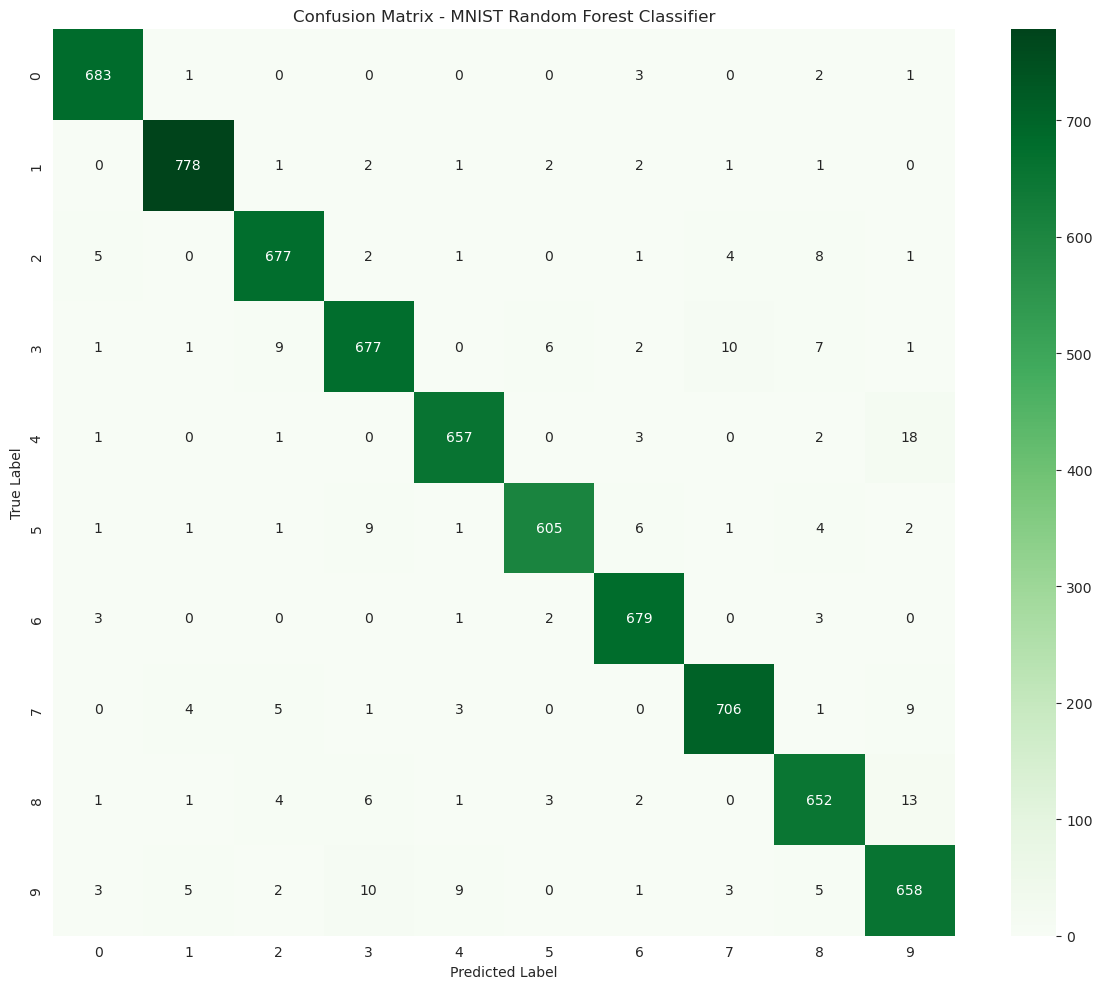


Calculating feature importance...


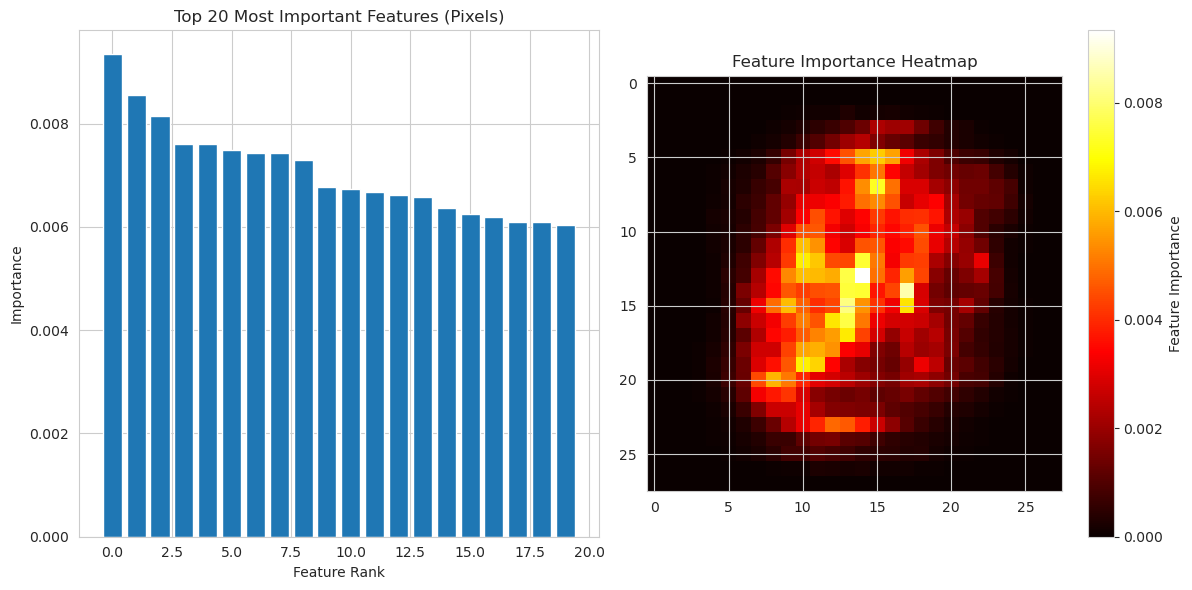


TOP 10 PARAMETER COMBINATIONS

Rank 1: Score = 0.9680 (+/- 0.0009)
Parameters: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 200}

Rank 2: Score = 0.9679 (+/- 0.0007)
Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 200}

Rank 3: Score = 0.9673 (+/- 0.0008)
Parameters: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 100}

Rank 4: Score = 0.9670 (+/- 0.0009)
Parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 200}

Rank 5: Score = 0.9668 (+/- 0.0006)
Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 100}

Rank 6: Score = 0.9666 (+/- 0.0007)
Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 200}

Rank 7: Score = 0.9664 (+/- 0.0008)
Parameters: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 200}

Rank 8: Sc

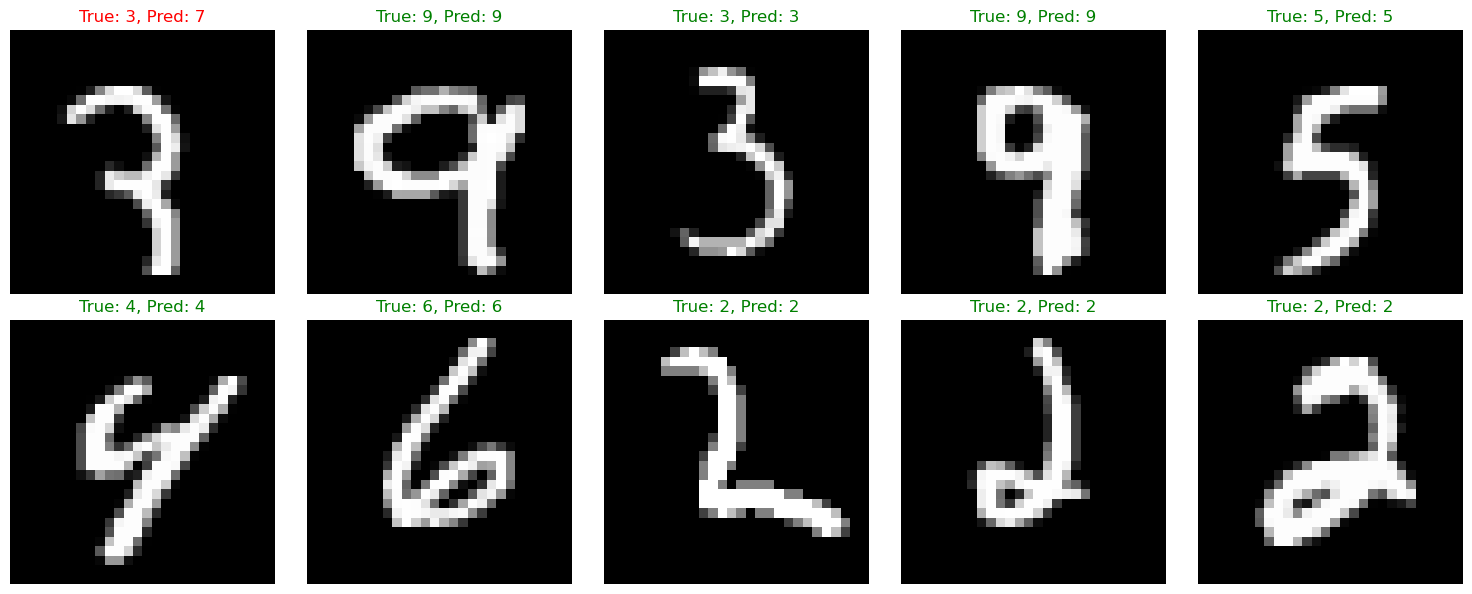


TRAINING COMPLETE!
Final Test Accuracy: 0.9674 (96.74%)
Best Model Parameters: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 200}


In [10]:
# MNIST Classification with Random Forest and Grid Search
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import time

# Load MNIST dataset
print("Loading MNIST dataset...")
mnist = fetch_openml('mnist_784', version=1, parser='auto')
X, y = mnist.data, mnist.target

# Convert to numpy arrays and ensure correct data types
X = np.array(X, dtype='float32')
y = np.array(y, dtype='int')

print(f"Dataset shape: {X.shape}")
print(f"Labels shape: {y.shape}")

# Split data: 80% training, 10% testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.10, random_state=42, stratify=y
)

print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")

# Note: Random Forest doesn't require feature scaling, but we can normalize pixel values
print("\nNormalizing pixel values to [0, 1] range...")
X_train = X_train / 255.0
X_test = X_test / 255.0

# Define Random Forest classifier
rf = RandomForestClassifier(random_state=42, n_jobs=-1, verbose=1)

# Define hyperparameter grid (reduced for efficiency)
param_grid = {
    'n_estimators': [100, 200],  # Number of trees
    'max_depth': [20, 30, None],  # Maximum depth of trees
    'min_samples_split': [2, 5],  # Minimum samples to split a node
    'max_features': ['sqrt', 'log2']  # Number of features to consider at each split
}

# Calculate total combinations
total_combinations = 2 * 3 * 2 * 2
print(f"\nStarting Grid Search with Cross-Validation...")
print(f"Total combinations to test: {total_combinations}")
print(f"With 3-fold CV, total fits: {total_combinations * 3}")

# Perform Grid Search with 3-fold cross-validation
grid_search = GridSearchCV(
    rf,
    param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2,
    refit=True
)

start_time = time.time()
grid_search.fit(X_train, y_train)
end_time = time.time()

print(f"\nGrid Search completed in {(end_time - start_time)/60:.2f} minutes")

# Best parameters and score
print("\n" + "="*60)
print("BEST HYPERPARAMETERS:")
print("="*60)
for param, value in grid_search.best_params_.items():
    print(f"{param}: {value}")

print(f"\nBest Cross-Validation Accuracy: {grid_search.best_score_:.4f}")

# Get the best model
print("\n" + "="*60)
print("EVALUATING FINAL MODEL WITH BEST PARAMETERS")
print("="*60)
best_model = grid_search.best_estimator_

# Predictions on test set
y_pred = best_model.predict(X_test)

# Calculate accuracy
test_accuracy = accuracy_score(y_test, y_pred)
train_accuracy = accuracy_score(y_train, best_model.predict(X_train))

print(f"\nTraining Accuracy: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
print(f"Testing Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

# Classification report
print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60)
print(classification_report(y_test, y_pred))

# Confusion Matrix
print("\nGenerating confusion matrix...")
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=range(10), yticklabels=range(10))
plt.title('Confusion Matrix - MNIST Random Forest Classifier')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Feature importance (top 20 pixels)
print("\nCalculating feature importance...")
feature_importance = best_model.feature_importances_
top_features_idx = np.argsort(feature_importance)[-20:][::-1]

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(range(20), feature_importance[top_features_idx])
plt.xlabel('Feature Rank')
plt.ylabel('Importance')
plt.title('Top 20 Most Important Features (Pixels)')
plt.tight_layout()

# Visualize important pixels on 28x28 grid
plt.subplot(1, 2, 2)
importance_grid = feature_importance.reshape(28, 28)
plt.imshow(importance_grid, cmap='hot', interpolation='nearest')
plt.colorbar(label='Feature Importance')
plt.title('Feature Importance Heatmap')
plt.tight_layout()
plt.show()

# Show top 10 parameter combinations
print("\n" + "="*60)
print("TOP 10 PARAMETER COMBINATIONS")
print("="*60)
results_df = pd.DataFrame(grid_search.cv_results_)
top_10 = results_df.nlargest(10, 'mean_test_score')[
    ['params', 'mean_test_score', 'std_test_score', 'rank_test_score']
]
for idx, row in top_10.iterrows():
    print(f"\nRank {int(row['rank_test_score'])}: Score = {row['mean_test_score']:.4f} (+/- {row['std_test_score']:.4f})")
    print(f"Parameters: {row['params']}")

# Visualize some predictions
print("\nVisualizing sample predictions...")
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
sample_indices = np.random.choice(len(X_test), 10, replace=False)

for idx, ax in enumerate(axes.flat):
    sample_idx = sample_indices[idx]
    image = (X_test[sample_idx] * 255).reshape(28, 28)  # Scale back for visualization
    true_label = y_test[sample_idx]
    pred_label = y_pred[sample_idx]

    ax.imshow(image, cmap='gray')
    color = 'green' if true_label == pred_label else 'red'
    ax.set_title(f'True: {true_label}, Pred: {pred_label}', color=color)
    ax.axis('off')

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("TRAINING COMPLETE!")
print("="*60)
print(f"Final Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Best Model Parameters: {grid_search.best_params_}")